# DSCI100-009-18 FINAL GROUP PROJECT

### Amelia Zhang, Jaza Khan, Sora Takamura, Yolanda Peng

## **Introduction**

Understanding how players engage with online games can help developers and computer science researchers design better systems and keep players active on the server. The UBC team of computer science researchers, led by Frank Wood, has created a Minecraft server that records detailed behavioural data from players who have different backgrounds. These data provide a unique opportunity to study how different players interact with the game. 

Newsletter subscription can serve as an indicator of players’ interest and engagement. Therefore, identifying which types of players are most likely to subscribe and understanding how their backgrounds and in-game behaviours differ is valuable for improving recruitment strategies. 

Our research question is:

> Can a player's experience level and played hours predict whether a player subscribes to a game-related newsletter?

To answer this question, we are using the dataset collected from the Minecraft research server, which contains players' basic information and behavioural variables.

## **Data Description**

This dataset contains `196 observations` and `7 variables`. Each row represents data from a single player, including their personal details and information when they play Minecraft.
The purpose of this dataset is to explore what player characteristics are more predictive of newsletter subscription. 

| Variable | Type | Description | Summary / Mean Value | Possible Issues |
|----------|------|-------------|----------------------|-----------------|
| `experience`| categorical | player's level of experience. | 5 levels: Beginner, Amateur, Regular, Veteran, and Pro. Most players fall into the Amateur group. |     |
| `subscribe`| categorical | TRUE if the player subscribed to the newsletter; FALSE otherwise. | TRUE: 142, FALSE: 52 |     |
| `hashedEmail` | character | anonymized player's email address. | NA |     |
| `played_hours` | numerical | total hours each player has spent playing the game. | mean: 5.90 (hours) | There seem to be outliers which may skew results hence data may need to be standardized. |
| `name` | character | name | NA |     |
| `gender` | categorical | gender. | This dataset has six gender identities, where the majority of players are male. |     |
| `Age` | numerical | age. | mean: 21.14 (years) | Type may need to be changed to type Integer to optimize for memory since that will not impact data regardless. |

In this project, the **response variable** is `subscribe`, which indicates whether a player has subscribed to the newsletter or not. The **explanatory variables** are `experience` and `played_hours` because these variables represent a player's characteristics and activity levels that would affect their decision to subscribe. Those irrelevant columns such as `hashedEmail`, `name`, `Age`, and `gender` will be removed in the data wrangling process. This dataset has behavioral information for each player, which makes it possible to examine subscription patterns across different player types and activity levels.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Loading the dataset

In [2]:
players <- read_csv("https://raw.githubusercontent.com/yolandapengx/dsci-100-project-009-18/refs/heads/main/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


## Data Wrangling

In [3]:
# selecting only the relevant columns/variables
players_clean <- players |>
    select(experience,
           subscribe,
           played_hours) |>
# # removing rows with missing values
#     filter(!is.na(Age)) |>
# # converting Age to integer type
#     mutate(Age = as.integer(Age)) |>
# changing true/false vals to subscribed/not-subscribed for easier readability
    mutate(subscribe = as.character(subscribe)) |>
    mutate(across('subscribe', str_replace, 'TRUE', 'subscribed')) |>
    mutate(across('subscribe', str_replace, 'FALSE', 'not subscribed')) |>
# converting categorial variables to factors
    mutate(subscribe = as_factor(subscribe)) |>
# converting experience to numerical values
    mutate(experience_num = case_when(
                experience == "Beginner" ~ 1,
                experience == "Regular" ~ 2,
                experience == "Amateur" ~ 3,
                experience == "Veteran" ~ 4,
                experience == "Pro" ~ 5))
players_clean

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `across("subscribe", str_replace, "TRUE", "subscribed")`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


experience,subscribe,played_hours,experience_num
<chr>,<fct>,<dbl>,<dbl>
Pro,subscribed,30.3,5
Veteran,subscribed,3.8,4
Veteran,not subscribed,0.0,4
⋮,⋮,⋮,⋮
Amateur,not subscribed,0.0,3
Amateur,not subscribed,2.3,3
Pro,subscribed,0.2,5


# Methods

In order to investigate whether a player's experience level and played hours could predict whether or not a player subscribes to a game-related newsletter, we used exploratory visual comparisons and a knn classification model.

Once we had loaded our dataset from our Github repository (originally from the Minecraft Research Server), we were able to wrangle it to remove columns irrelevant to our purposes, like hashedEmail, name, Age, and gender. We then re-distinguished our experience variable with numerical values to make it easier for us to use the knn model later on in our analysis, but kept the original experience column as well for readability. In the end, we went from 7 variables to 4 variables. We also replaced the subscribe variable's values from TRUE and FALSE to subscribed and not subscribed, to again increase human readability. Lastly, we then converted the categorial variables subscribe, experience, and gender from data type \<chr> to \<fct> using the as_factor function.

In order to build a more clear understanding of our dataset and the relationships within it, we calculated the mean age of the players (approx. 21 years old), mean played hours (5.9 hours) and created two key visualizations (both of them bar charts).

Based on these summary statistics and preliminary explorations, we decided to implement a knn classification model with subscribe as our response variable and the experience level and played_hours variables as predictors. We set up a random seed to ensure reproducibility and then split the data into training (80%) and testing (20%) sets. Using this training set we created a workflow where we preprocessed all of our categorical variables into dummy variables and used the generalized linear model (glm) to train our model. Once we had our workflow, we used the tidy() method to see our coefficient estimates in order to see how each of our predictor variables contributed to subscription likelihood. After which, we used our testing data to evaluate the efficiency of our model and to generate test predictions. We found our model metrics (accuracy and kap) and also constructed a confusion matrix to evaluate whether our model is able to correctly predict/classify our different variables. These evaluation steps, especially accuracy and the confusion matrix, were essential to assessing model performance and determining where we could improve.


# Results

## 1. Summary of Player Characteristics

After cleaning the data by removing rows with missing age values and keeping
only relevant variables (experience, subscribe, played_hours, gender, Age),
we obtained a dataset with 194 players.

The summary statistics show that the the average total played hours is about 5.8 hours. Most players are
classified as Amateur in terms of experience. These descriptive results indicate that the dataset contains a moderately active player population, suitable for modelling newsletter subscription behaviour.

### Mean Values

In [4]:
players_mean <- players_clean |>
select(played_hours) |>
summarize(Mean_Played_Hours = mean(played_hours, na.rm = TRUE))

players_mean

Mean_Played_Hours
<dbl>
5.845918


## 2. Subscription Proportions Across Experience Levels

**Figure 1** shows the proportion of players who subscribed to the newsletter
for each experience level.

Surprisingly, players with an regular, beginner, or amateur experience have the highest ratios of subscribed vs. not subscribed, with regular having the greatest proportion of subscribers compared to non-subscribers. It appears that as players get more and more experienced, they are in fact less likely to subscribe to the newsletter, perhaps due to a lack of need for it.


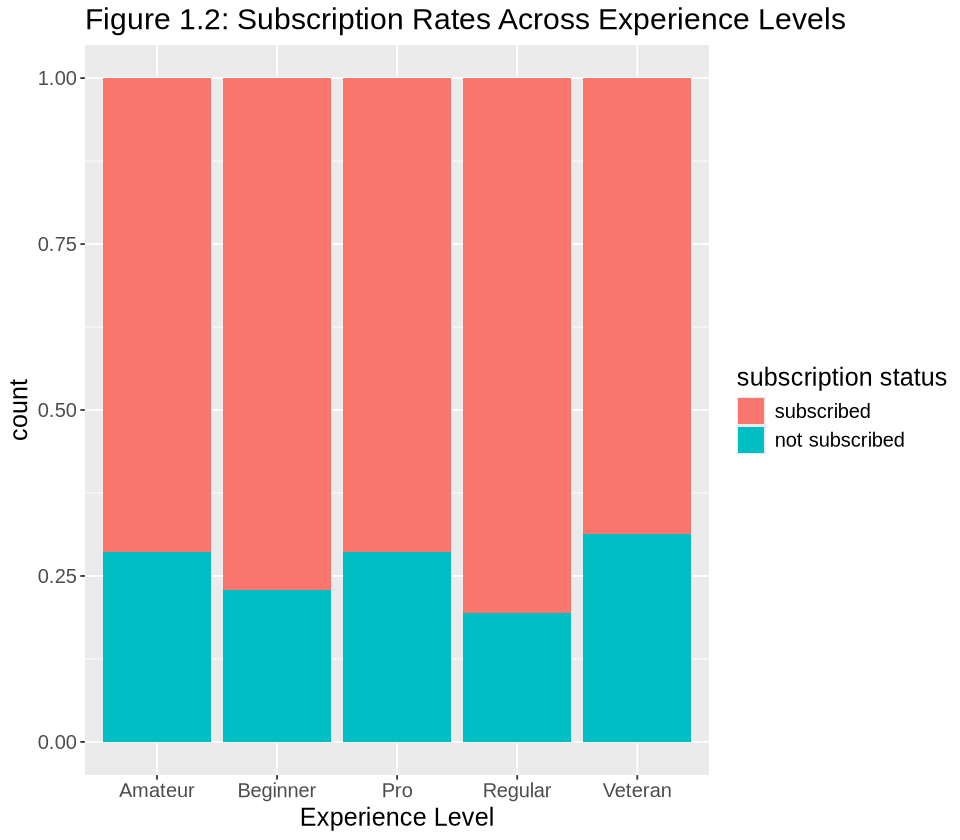

In [5]:
options(repr.plot.width = 8, repr.plot.height = 7)

fig1 <- players_clean |>
            group_by(experience) |>
            ggplot(aes(x = experience, fill = subscribe)) + 
            geom_bar(position = "fill") +
            labs(title = "Figure 1.2: Subscription Rates Across Experience Levels",
       x = "Experience Level",
       fill = "subscription status") +
  theme(text = element_text(size = 15))
fig1

## 3. Played Hours by Subscription Status

**Figure 2** compares the distribution of total played hours between players
who subscribed and those who did not.

Subscribers tend to have much higher median played hours (about 8 hours) whereas, in contrast, non-subscribers generally
show lower average playtime (less than 1 hour). This pattern suggests that players
who invest more time in the game are more likely to subscribe to the
newsletter, consistent with the idea that higher engagement leads to greater
interest in game-related updates.

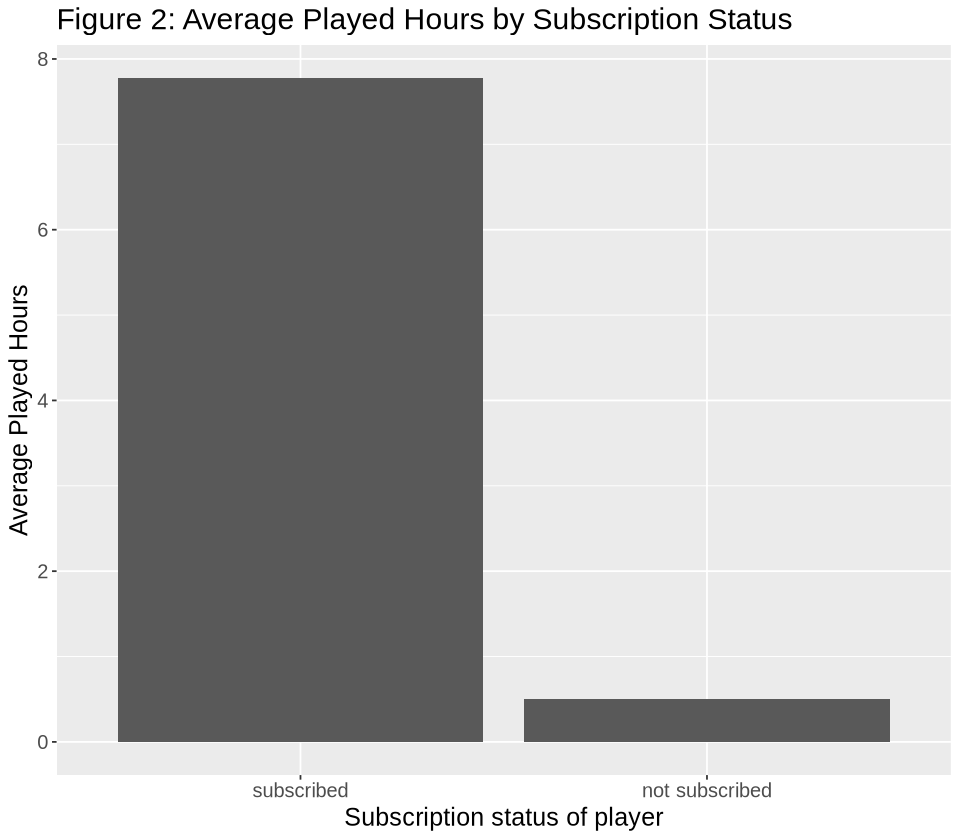

In [6]:
fig2 <- players_clean |>
        group_by(subscribe) |>
        summarize(average_played_hours = mean(played_hours)) |>
  ggplot(aes(x = subscribe, y = average_played_hours)) +
  geom_bar(stat = "identity") +
  labs(title = "Figure 2: Average Played Hours by Subscription Status",
       x = "Subscription status of player",
       y = "Average Played Hours") +
  theme(text = element_text(size = 15))

fig2

## 4. Preliminary Scatter Plot of Playtime versus Experience Level

This is a preliminary visualization made to help us see the relationship between players' number of played hours and their experience level, as well as if there are any patterns in how the subscription status is colored across the graph. It will help us when we begin our KNN classification predictive analysis.

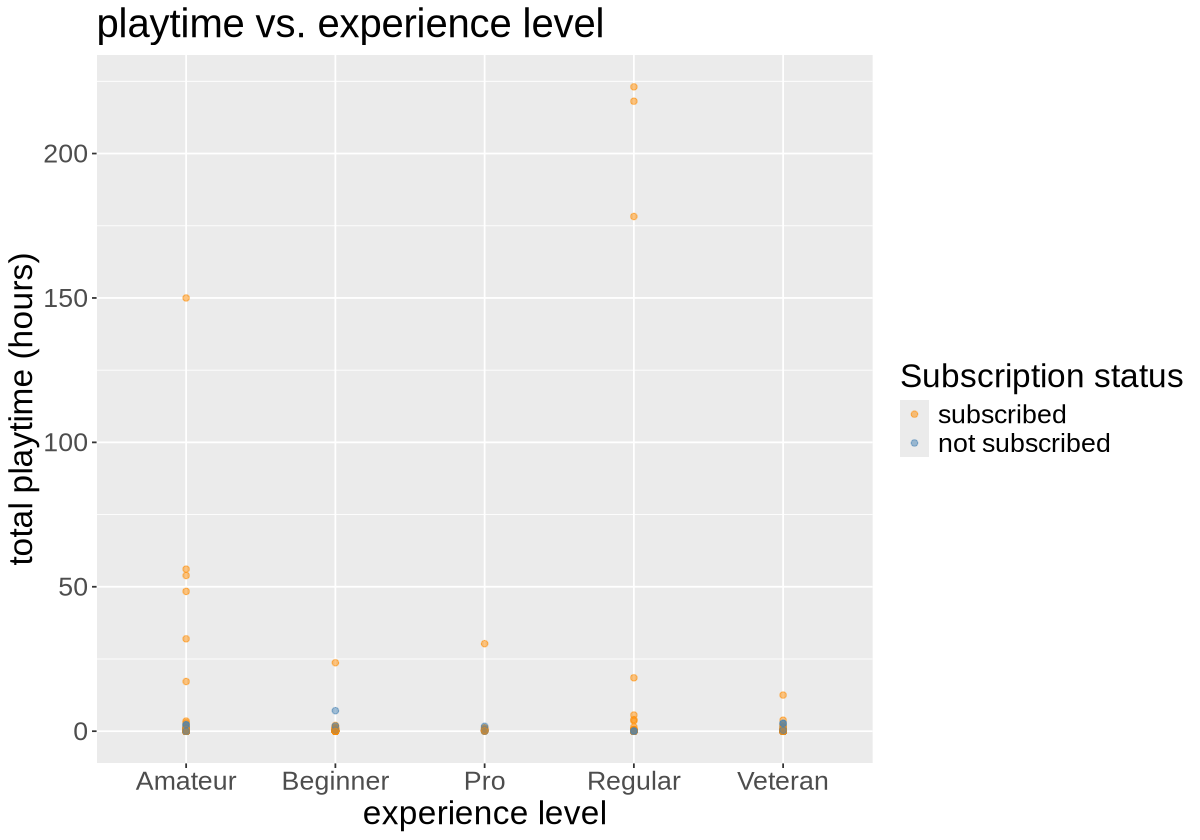

In [7]:
options(repr.plot.width = 10, repr.plot.height = 7)

players_scatter <- players_clean |>
  ggplot(aes(x = experience, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.5) +
  labs(color = "Subscription status", x = "experience level", y = "total playtime (hours)", title = "playtime vs. experience level") +
  scale_color_manual(values = c("darkorange", "steelblue")) +
  theme(text = element_text(size = 20))

players_scatter

## 4. K Nearest Neighbors Classification Model

To investigate which variables predict newsletter subscription, we fitted a
k-nearest neighbours classification model using subscribe as the response variable and
experience and played_hours as predictors.

In [8]:
set.seed(123)

# Splitting original data
data_split <- initial_split(players_clean, prop = 0.8, strata = subscribe)
train_data <- training(data_split)
test_data  <- testing(data_split)

# creating recipe
players_recipe <- recipe(subscribe ~ experience_num + played_hours,
                     data = train_data) |>
                     step_scale(all_predictors()) |>
                     step_center(all_predictors())

### Model Performance/Finding Best K-value

To test the prediction accuracy of our knn classifier, we will be using 5-fold cross validation on our training data to get an estimated accuracy percentage for how well our model can predict whether or not a player is subscribed to the newsletter for different values of k. We will then choose the k value that gives us the higher average accuracy to complete our final predictive analysis.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.4804435,5,0.03541106,Preprocessor1_Model1
3,accuracy,binary,0.5058468,5,0.03767573,Preprocessor1_Model2
4,accuracy,binary,0.4933468,5,0.03203616,Preprocessor1_Model3
5,accuracy,binary,0.5127016,5,0.01639027,Preprocessor1_Model4
6,accuracy,binary,0.5189516,5,0.01912243,Preprocessor1_Model5


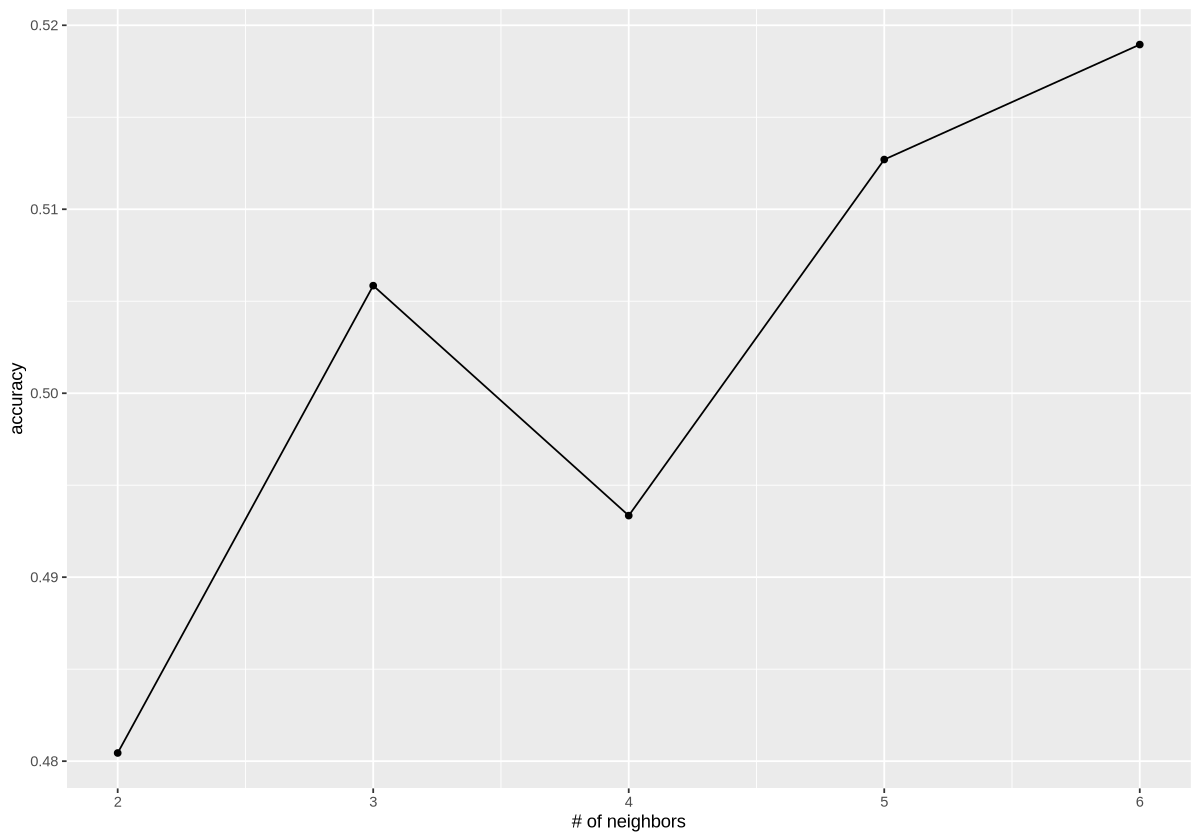

In [9]:
set.seed(123)
# cross validation to find the predictive accuracy

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

training_recipe <- recipe(subscribe ~ played_hours + experience_num,
                        data = train_data) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

training_vfold <- vfold_cv(train_data, v = 5, strata = subscribe)

knn_results <- workflow() |>
                 add_recipe(training_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = training_vfold, grid = tibble(neighbors = c(2,3,4,5,6))) |>
                 collect_metrics() |>
                 filter(.metric == "accuracy")
knn_results

cross_val_plot <- ggplot(knn_results, aes(y = mean, x = neighbors)) +
                geom_point() +
                geom_line() +
                labs(y = "accuracy", x = "# of neighbors")
cross_val_plot

From the plot above, we can see that the number of neighbours with the highest accuracy is k = 6, therefore that is what we will choose when completing the formal analysis.

### Creating Confusion Matrix and Using Model on Test Data

In [10]:
set.seed(123)

players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) |> # using the k-value we found from our analysis above
       set_engine("kknn") |>
       set_mode("classification")

players_fit <- workflow() |>
             add_recipe(players_recipe) |>
             add_model(players_spec) |>
            fit(data = train_data)
players_fit

players_predictions <- predict(players_fit, test_data) |>
                    bind_cols(test_data)
players_predictions

players_metrics <- metrics(players_predictions, truth = subscribe, estimate = .pred_class) |>
                filter(.metric == "accuracy")
players_metrics

players_conf_mat <- conf_mat(players_predictions, truth = subscribe, estimate = .pred_class)
players_conf_mat

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3333333
Best kernel: rectangular
Best k: 6

.pred_class,experience,subscribe,played_hours,experience_num
<fct>,<chr>,<fct>,<dbl>,<dbl>
subscribed,Veteran,subscribed,3.8,4
not subscribed,Veteran,not subscribed,0.0,4
not subscribed,Amateur,not subscribed,0.0,3
⋮,⋮,⋮,⋮,⋮
subscribed,Pro,not subscribed,0.2,5
not subscribed,Amateur,not subscribed,0.0,3
not subscribed,Amateur,subscribed,0.0,3


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.475


                Truth
Prediction       subscribed not subscribed
  subscribed             12              4
  not subscribed         17              7

# Discussion

## Summary of Findings

Across all analyses, several consistent patterns emerge:

- Players with **more played hours** are more likely to subscribe to the
  newsletter, indicating that in-game engagement strongly relates to
  external engagement.
- Players with **lower experience levels** (such Amateur and Beginner) show
  higher subscription rates than Veterans and Pros.
- The k-nearest neighbors model achieves **poor predictive performance** of about 48% accuracy,
  suggesting that player characteristics and activity levels do not necessarily contain useful
  information for predicting subscription, and that other unobserved factors
  likely play a role.

Overall, the results support the idea that more active
players with less ecperience are more likely to subscribe to game-related newsletters. However, 
it also demonstrates that while there is a correlation between these two variables and subscription status,
it doesn't necessarily mean causation, as we can see from the poor predictive performance result. This
provides useful guidance for targeting communication or designing
engagement strategies for different types of players.

## Expectations vs. Results

The results we uncovered through our data analysis align relatively closely with what we expected to find. It makes sense that individuals with higher than average commitment to the game, whether it be through experience or hours played, would show an increased interest in a newsletter subscription that likely details new updates, events, promotions, etc. related to the game. The weaker effects of the players' age and gender on subscription was slightly surprising, but understandable as playtime and experience level can vary widely between players of all ages and gender types. 

## Impact

The impact of our findings could flow down various routes. Firstly, our analysis informs newsletter writers to better understand their demographic of readers. They can use this data to decide what events to promote, what style/trends to adhere to for higher engagement, what topics to focus on based on the preferences of these specific types of players, and so on. Secondly, our results are also able to assist in the promotion of the newsletter itself. Long-time players with greater experience and a higher number of logged played hours (ie. players with a higher predicted likelihood of being a subscriber) could have more promotional content and notifications pushed on them, rather than those with a lesser predicted likelihood of being a subscriber. This will impact the success of the newsletters, while at the same time forcing newsletter writers to think about how to appeal to these less experienced and/or less playtime individuals in order for their newsletter to reach a wider audience of players. Lastly, the analysis that shows our model demonstrates a moderate predictive performance, suggesting that other unobserved factors may play an additional role in newsletter subscription may be useful in informing the researchers to look into other possible contributing factors beyond what they already have. 

## Future Questions

Expanding on the last point made in the "Impacts" section of this report, our moderate predictive performance ability stimulates the question of what other factors could act as a possible contributor to subscription status other than experience and played hours, and more so than age and gender. It also generates the question of what can be changed about the newsletter so that it appeals to players with less played hours and/or experience as well? It may be of interest to investigate whether this lack of subscriptions from individuals with less played hours and/or experience is solely due to the fact that they may just be inherently less interested in the game itself, or if it's because they feel specifically that the newsletter doesn't appeal to their more beginner level interests, whether it be due to a sense of exclusivity, lack of knowledge regarding certain game terminology, or lack of events and information that benefits them. All of these questions would be meaningful to look into further in order to benefit player engagement, inclusivity, and the overall success of the newsletter in spreading information. 